Model orthogonalization with LDM variants (heavily based on Vojta's original code "toymodels.ipynb"). This is an interactive jupyter notebook, that will explore different choices for the construction of the principal components. For now we will only play with the following scenarios:


* 1 good model 1 bad model
* 3 good models 10 bad models
* 1 pefect model, 3 good models, 10 bad models



This is the code hierarchy:

    ├── Utilities
    └── Version 2.0 - LDM variants: Data preparation
    └── PCA - Analysis

        
**I recommend to have Collapsible Headings nbextension active for the best experience.**

## Utilities

In [51]:
pip install corner 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import corner 


#Some colors that Pablo likes:
colors = [
    "#ff7f0e",

    "#1f77b4",

    "#2ca02c",
    "#d62728",
    
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
] 

markers = [
    "o",  # Circle
    "^",  # Triangle up
    "s",  # Square
    "P",  # Plus (filled)
    "*",  # Star
    "X",  # X (filled)
    "D",  # Diamond
    "H",  # Hexagon
]
def LDM_extended(params, x): 
    #x = (n,z)
    #params= parameters (volume, surface, curv, sym, ssym, sym_2, Coulomb)
    
    n=x[0]
    z=x[1]
    A = n + z
    I = (n-z)/(n+z)
    #I = 0

    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4) + params[6]*((z**2)/((n+z)**(4/3))) 




def Truth(x):
    return LDM(LDM_truth_params,x)

def data_loader():
    #input_NZ = pd.read_csv("NZ.txt", delim_whitespace=True, header = None)
    input_NZ = pd.read_csv("NZ_even_even.txt", delim_whitespace=True, header = None)
    input_NZ.columns = ["N", "Z"]
    return input_NZ

def loading_matrix(loadings, n_features, feature_names):
    # Loadings

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')
    return loadings_df

def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=5, color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    return


def plot_bars(values, labels, title="Bar Plot", color='blue'):
    """
    Create a bar plot based on the provided values and labels.

    Parameters:
    - values (list): A list of numerical values for the bars.
    - labels (list): A list of labels for each bar.
    - title (str): The title for the bar plot. Default is "Bar Plot".
    - color (str): Color for the bars. Default is 'blue'.
    """
    
    if len(values) != len(labels):
        raise ValueError("Length of values and labels should be the same.")
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Vt Coordinates')
    plt.xticks(labels,fontsize=10,rotation='vertical')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()




### Global variables####

# SkO values selected for the truth

truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

PerfectM_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

# SLy4 
GoodM_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1, 0.57]
# NL_1
BadM_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3, 0.57]



# NL_1 
TerribleM_params = [-15.972, 18.4, 9, 0, 0, 0, 0.57]


noise_term_p=0.01
noise_term_g=0.05
noise_term_b=0.05
noise_term_t=0.05

TestingFraction=0.3





##########################

## Version 2.0 - LDM variants

In [7]:

scenario = "1g1b"
# scenario = "3g10b"
# scenario = "1p3g10b"
# Fix random seed
np.random.seed(142857)
n_perfect =0 
n_good = 3
n_bad = 5
n_terrible=10

n_classes=[n_perfect,n_good,n_bad,n_terrible]
n_Labels=["Perfect Model", "Good Model", "Intermediate Model","Bad Model"]

# Load NZ
input_NZ =  data_loader()





# masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) 

models_output = {}
models_output_train = {}
models_output_test = {}


#Perfect Models Loop
params = PerfectM_params
for i in range(n_perfect):
    models_output[str("PerfectModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_p


#Good Models Loop
params = GoodM_params
for i in range(n_good):
    models_output[str("GoodModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_g

#Bad Models Loop
params = BadM_params
for i in range(n_bad):
    models_output[str("IntermediateModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_b

#Terrible Models Loop
params = TerribleM_params
for i in range(n_terrible):
    models_output[str("BadModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_t



# Model_keys=models_output.keys()  #This is done here to have a list of pure models, without the ground truth
key_list=list(models_output.keys())

models_output['truth']=LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) 


models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]


models_output_train, models_output_test = train_test_split(models_output_df, test_size=0.3, random_state=142857)

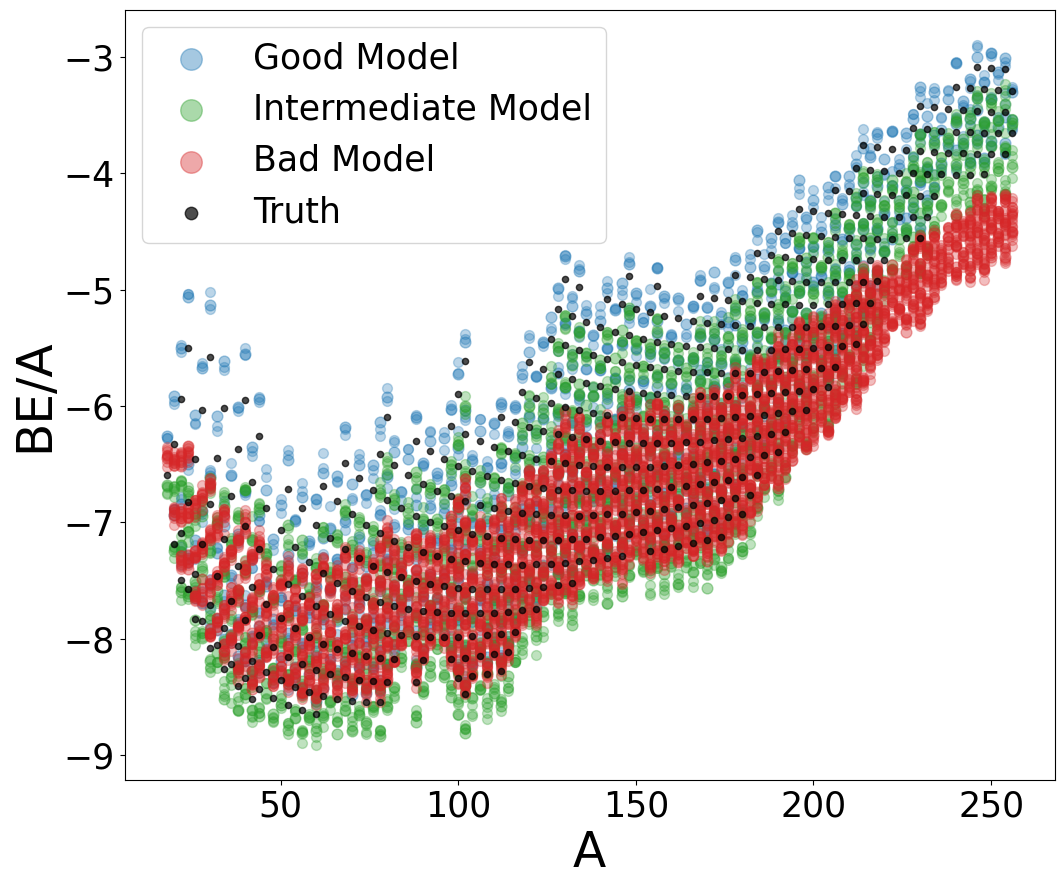

In [8]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.scatter(x = models_output_df["A"], y = models_output_df[key_list[model_index]], label = n_Labels[class_index], alpha = 0.4,color=colors[class_index],marker=markers[0],s=60)
        else:
            ax.scatter(x = models_output_df["A"], y = models_output_df[key_list[model_index]],  alpha = 0.3,color=colors[class_index],marker=markers[0],s=50)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0





ax.scatter(x = models_output_df["A"], y = models_output['truth'], label = "Truth", alpha = 0.7,color='k',s=20)


plt.xlabel("A",fontsize=35)
plt.ylabel("BE/A",fontsize=35)
plt.legend(fontsize=25,markerscale=2 )
plt.savefig("LDM_Data_"+scenario+".pdf", format="pdf", bbox_inches="tight")
plt.show()

In [9]:
residuals = models_output['truth'].values[:,None] - models_output_df[key_list].values 

residuals_train = models_output_train['truth'].values[:,None] - models_output_train[key_list].values 

residualss_test  = models_output_test['truth'].values[:,None] - models_output_test[key_list].values 



model_predictions=models_output_df[key_list].values
model_predictions_train=models_output_train[key_list].values
model_predictions_test=models_output_test[key_list].values






model_summary = {}
# model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
# model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
# model_summary["res_mean"] = residuals.mean(axis = 0)
# model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse_all"] = np.sqrt(np.mean(residuals ** 2, axis = 0))
model_summary["rmse_train"] = np.sqrt(np.mean(residuals_train ** 2, axis = 0))
model_summary["rmse_test"] = np.sqrt(np.mean(residualss_test ** 2, axis = 0))


model_summary_df = pd.DataFrame(model_summary, index =key_list)
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                     rmse_all  rmse_train  rmse_test
GoodModel_0          0.147723    0.149131   0.144407
GoodModel_1          0.147652    0.146615   0.150028
GoodModel_2          0.146309    0.144496   0.150429
IntermediateModel_0  0.305495    0.304567   0.307635
IntermediateModel_1  0.305119    0.304363   0.306867
IntermediateModel_2  0.302654    0.301759   0.304718
IntermediateModel_3  0.307453    0.306272   0.310176
IntermediateModel_4  0.306691    0.306642   0.306804
BadModel_0           0.593913    0.581402   0.621953
BadModel_1           0.593913    0.579605   0.625828
BadModel_2           0.592238    0.577611   0.624834
BadModel_3           0.593506    0.580189   0.623286
BadModel_4           0.596250    0.580154   0.631993
BadModel_5           0.594728    0.581638   0.624021
BadModel_6           0.592884    0.581370   0.618755
BadModel_7           0.595070    0.583013   0.622126
BadModel_8           0.594446    0.581163   0.624158
BadModel_9           0.589361    0.575450   0.

In [10]:
Z_range=(20,20)
N_range=(0,300)


filtered_models_output = models_output_df[(models_output_df['Z'] >= Z_range[0]) & (models_output_df['Z'] <= Z_range[1]) & 
                     (models_output_df['N'] >= N_range[0]) & (models_output_df['N'] <= N_range[1])]

filtered_models_output_test = models_output_test[(models_output_test['Z'] >= Z_range[0]) & (models_output_test['Z'] <= Z_range[1]) & 
                     (models_output_test['N'] >= N_range[0]) & (models_output_test['N'] <= N_range[1])]


filtered_models_output_train = models_output_train[(models_output_train['Z'] >= Z_range[0]) & (models_output_train['Z'] <= Z_range[1]) & 
                     (models_output_train['N'] >= N_range[0]) & (models_output_train['N'] <= N_range[1])]

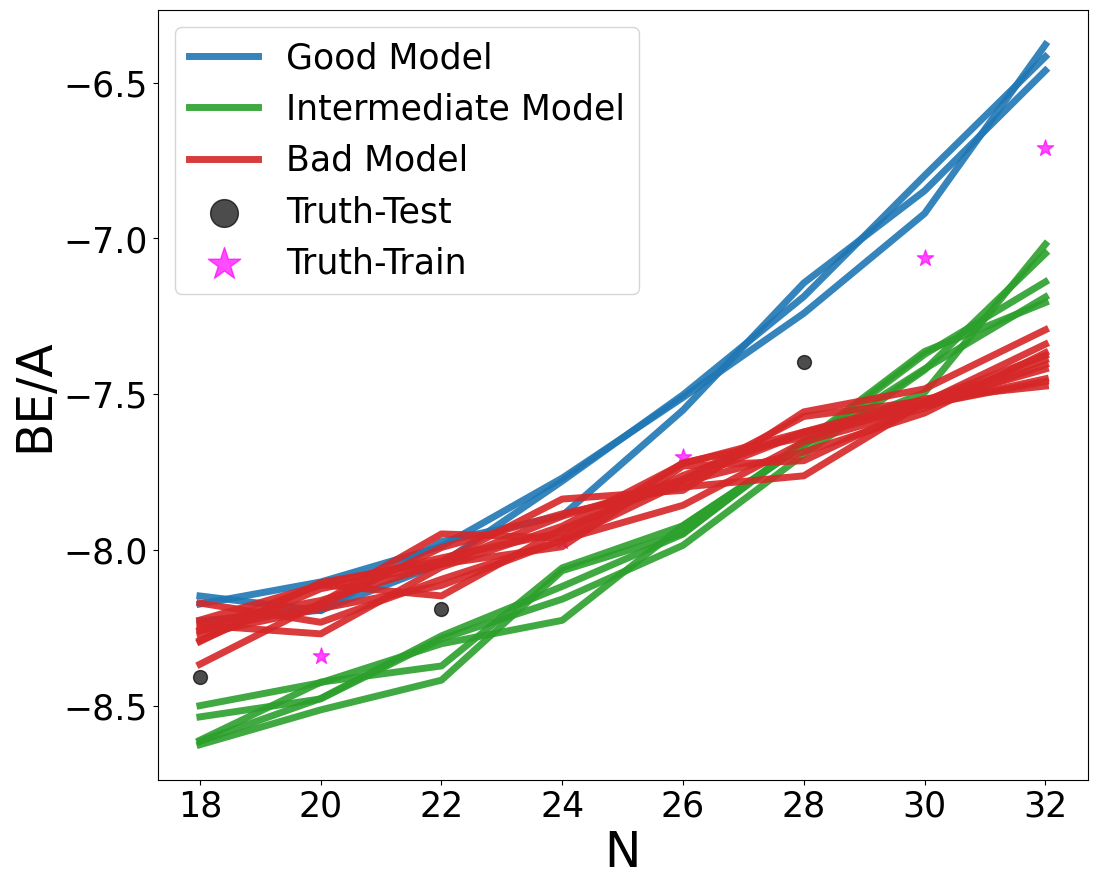

In [11]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = 0.9,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = 0.9,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0





ax.scatter(x = filtered_models_output_train["N"], y = filtered_models_output_train['truth'], label = "Truth-Test", alpha = 0.7,color='k',s=100)
ax.scatter(x = filtered_models_output_test["N"], y = filtered_models_output_test['truth'], label = "Truth-Train", alpha = 0.7,color='magenta',s=150,marker="*")


plt.xlabel("N",fontsize=35)
plt.ylabel("BE/A",fontsize=35)
plt.legend(fontsize=25,markerscale=2 )
plt.savefig("LDM_Data_Calcium_"+scenario+".pdf", format="pdf", bbox_inches="tight")
plt.show()

## PCA - Analysis (with centering)

###  1 Good 1 Bad 1 Terrible (noise)

In [12]:
predictions_mean= np.mean(model_predictions, axis=1)
predictions_train_mean= np.mean(model_predictions_train, axis=1)
predictions_test_mean= np.mean(model_predictions_test, axis=1)

In [13]:
model_predictions_train_centered=np.array([model_predictions_train.T[j]-predictions_train_mean for j in range(len(model_predictions_train.T))]).T

In [14]:
U, S, Vt = np.linalg.svd(model_predictions_train_centered)

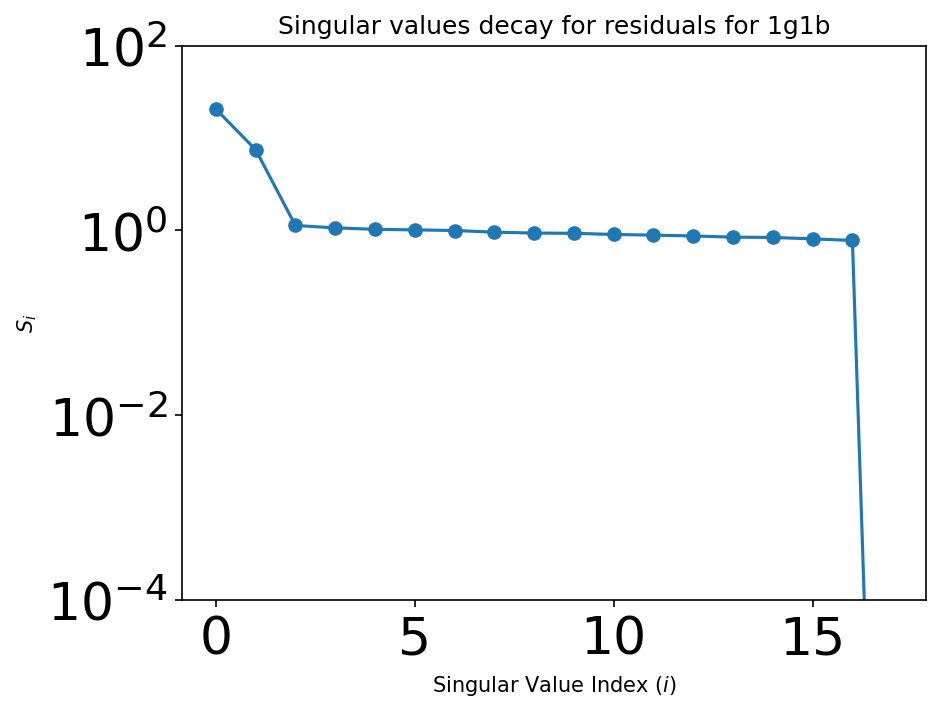

In [15]:
fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(S.size), S)
ax.plot(np.arange(S.size), S)

ax.set_yscale('log')
ax.set_xlabel(r'Singular Value Index ($i$)')
ax.set_ylabel(r'$S_i$');
plt.ylim(10**(-4),100)
plt.title("Singular values decay for residuals for " +scenario)
plt.show()

In [16]:
components_kept=2
S_hat=np.array([S[i] for i in range(components_kept)])

U_hat=np.array([U.T[i]*S_hat[i] for i in range(components_kept)])

Vt_hat=np.array([Vt[i] for i in range(components_kept)])


In [17]:
models_PC = {}


models_PC[str("PC_0")] = predictions_mean
for i in range(components_kept):
    models_PC[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions.T)*S_hat[i]


models_PC = pd.DataFrame(models_PC)
models_PC["N"] = input_NZ["N"]
models_PC["Z"] = input_NZ["Z"]
models_PC["A"] = models_PC["N"] + models_PC["Z"]

In [18]:
filtered_models_PC = models_PC[(models_PC['Z'] >= Z_range[0]) & (models_PC['Z'] <= Z_range[1]) & 
                     (models_PC['N'] >= N_range[0]) & (models_PC['N'] <= N_range[1])]

In [19]:
key_list_PCs=list(filtered_models_PC.keys())

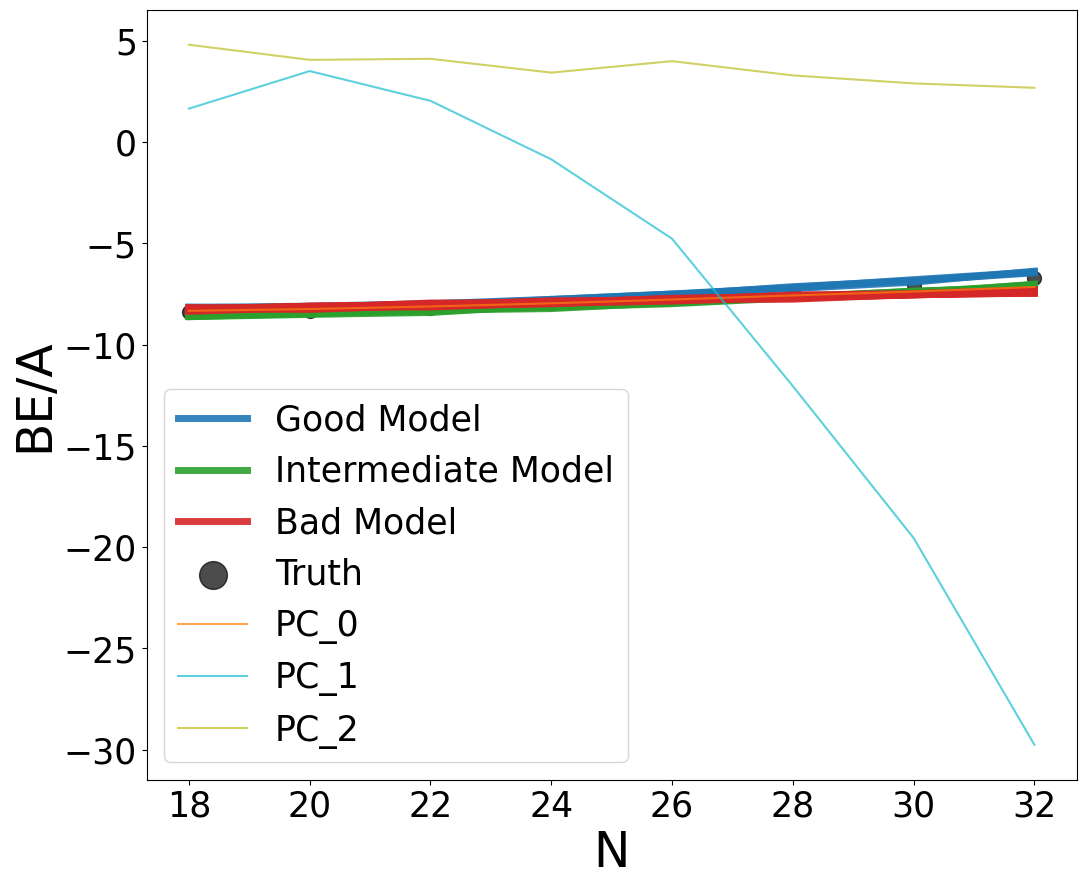

In [20]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = 0.9,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = 0.9,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0







ax.scatter(x = filtered_models_output["N"], y = filtered_models_output['truth'], label = "Truth", alpha = 0.7,color='k',s=100)

for i in range(components_kept+1):
    ax.plot(filtered_models_PC["N"], filtered_models_PC[key_list_PCs[i]], label =key_list_PCs[i], alpha = 0.7,color=colors[-i])






plt.xlabel("N",fontsize=35)
plt.ylabel("BE/A",fontsize=35)
plt.legend(fontsize=25,markerscale=2 )
plt.savefig("LDM_Data_Calcium_"+scenario+".pdf", format="pdf", bbox_inches="tight")
plt.show()

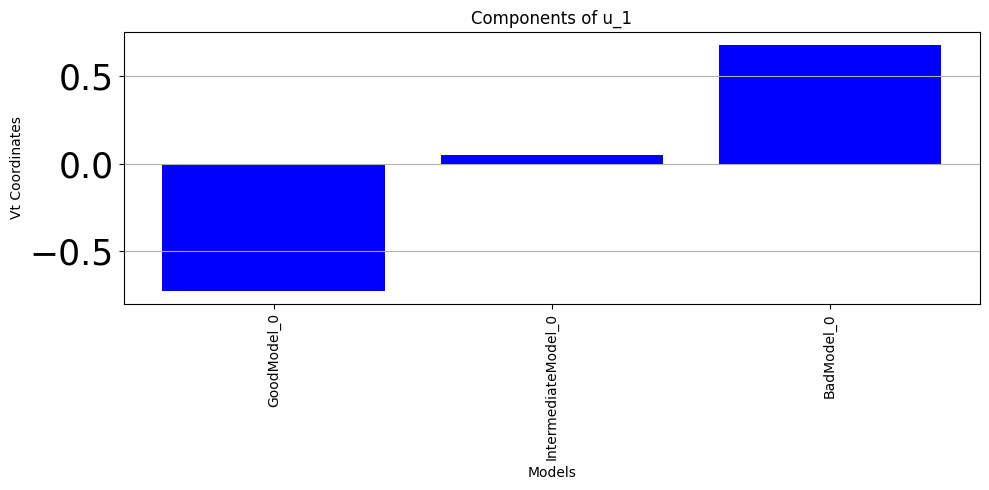

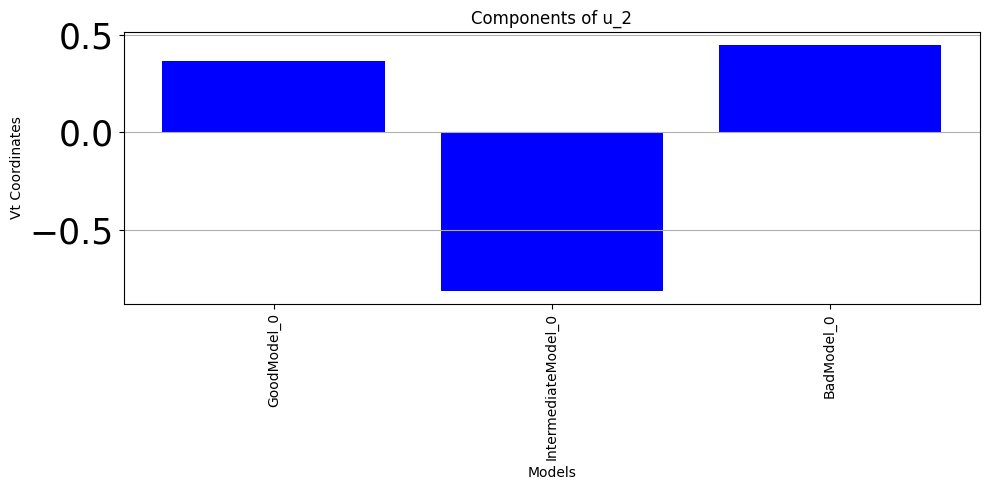

In [ ]:


for i in range(len(Vt_hat)):

    plot_bars(Vt_hat[i], key_list, title=f"Components of u_{i+1}", color='blue')

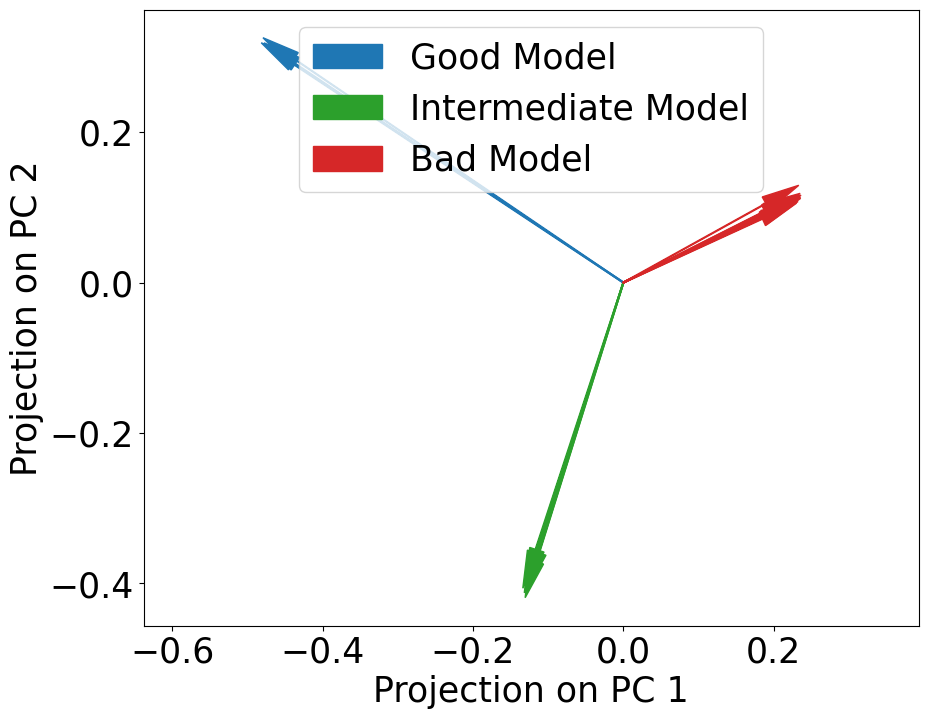

In [22]:

list1 = Vt_hat.T[0:1]
list2 = Vt_hat.T[1:] 

plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(10,8), dpi=100)

model_index=0
class_index=0

visited_model=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1

            plt.arrow(0, 0, Vt_hat.T[visited_model][0], Vt_hat.T[visited_model][1], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index],label=n_Labels[class_index])
           
        else:
            plt.arrow(0, 0, Vt_hat.T[visited_model][0], Vt_hat.T[visited_model][1], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index])
        model_index=model_index+1
        visited_model=visited_model+1
    class_index=class_index+1
    legend_flag=0


# Determine plot limits based on the maximum absolute values of the vectors
# max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
# plt.xlim(-max_val-1, max_val+1)
# plt.ylim(-max_val-1, max_val+1)

plt.xlabel('Projection on PC 1',fontsize=25)
plt.ylabel('Projection on PC 2',fontsize=25)

plt.legend(fontsize=25)

plt.axis('equal')

plt.show()


In [31]:
X=np.copy(U_hat)
y=np.copy(models_output_train["truth"].tolist())-predictions_train_mean

In [32]:
# 1) Find the least square solution
X_T_X_inv = np.linalg.inv(X.dot(X.T))
beta = X_T_X_inv.dot(X).dot(y)
supermodel=X.T.dot(beta)

# 2) Construct the covariance matrix
residuals = y - supermodel
sigma_squared = np.sum(residuals**2) / len(residuals) 
cov_matrix = sigma_squared * X_T_X_inv

# 3) Make a corner plot
samples = np.random.multivariate_normal(beta, cov_matrix, size=500000)


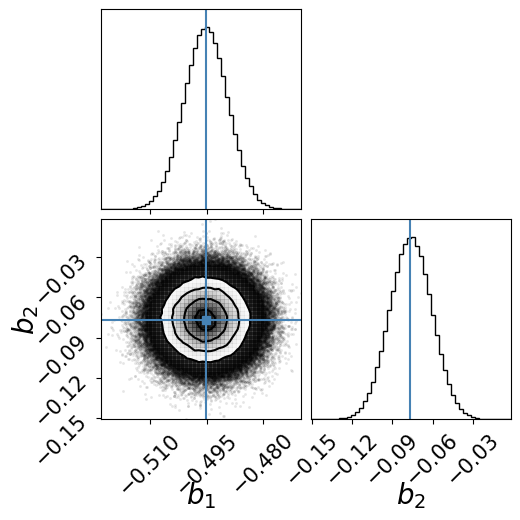

In [33]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

figure = corner.corner(samples,bins=50, labels=[f'$b_{i}$' for i in range(1, len(beta) + 1)], truths=beta,label_kwargs={"fontsize": 20},)

plt.show()

In [37]:
# 4) Make a corner plot in the space of the original models
samples_original_space = np.array([np.dot(betaval,Vt_hat)  for  betaval in samples])


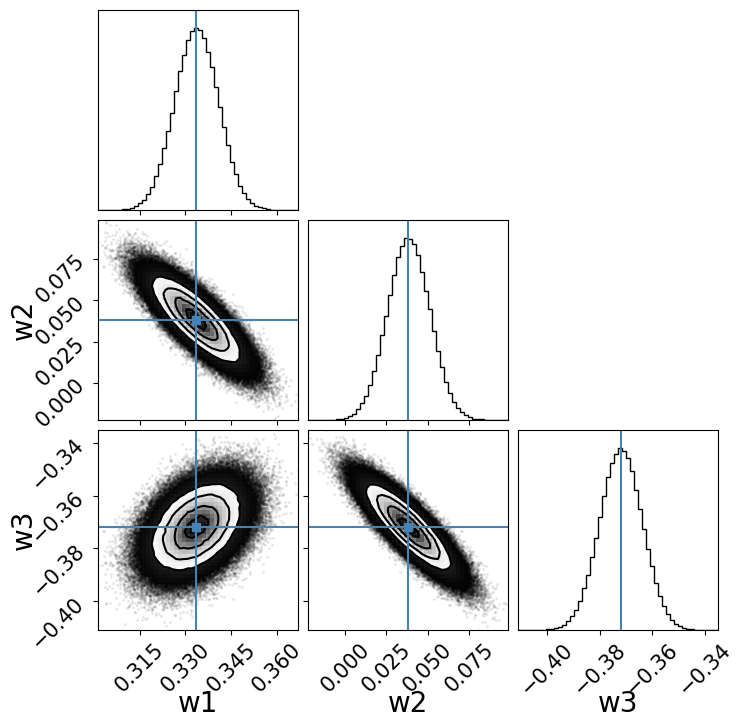

In [39]:


figure = corner.corner(samples_original_space, bins=50, labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat),label_kwargs={"fontsize": 20})
# figure = corner.corner(samples_original_space)

plt.show()

In [15]:
beta

array([0.69140697, 0.6705039 ])

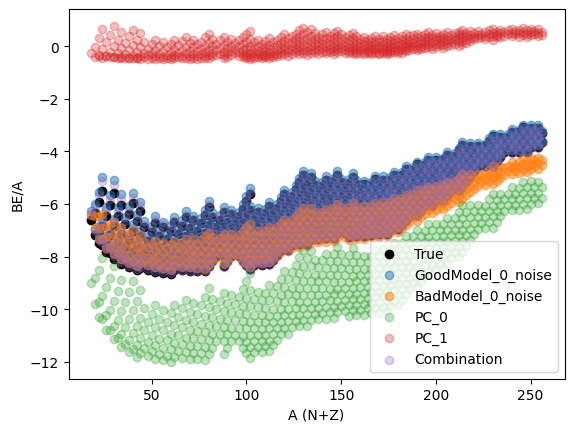

In [16]:
# for key in models_output.keys():
#     plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = masses_truth.values[:,None], label = str("True"), color='k')



for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
# 


# for i in range(components_kept):
plt.scatter(x = models_output_df["A"], y =U_hat.T[0], label = str("PC_") + str(0), alpha = 0.3)
plt.scatter(x = models_output_df["A"], y = U_hat.T[1], label = str("PC_") + str(1), alpha = 0.3)


# plt.scatter(x = models_output_df["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = supermodel, label = str("Combination"), alpha = 0.3)


plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

In [17]:
Z_range=(20,20)
N_range=(0,300)


filtered_models_output = models_output_df[(models_output_df['Z'] >= Z_range[0]) & (models_output_df['Z'] <= Z_range[1]) & 
                     (models_output_df['N'] >= N_range[0]) & (models_output_df['N'] <= N_range[1])]

In [18]:
Predictions_supermodel=supermodel[filtered_models_output.index]
masses_truth_filtered= np.array(masses_truth.tolist())[filtered_models_output.index]

In [19]:
rng = np.random.default_rng()
theta_rand = rng.choice(samples, (50000), replace=False)
rndm_m = []

for i in range(len(theta_rand)):
    yvals_rand= X.T.dot(theta_rand[i])[filtered_models_output.index]
    rndm_m.append(yvals_rand +
                   np.random.multivariate_normal(np.full(
                       len(masses_truth_filtered)
                       ,0), np.diag(1.0 * np.full(len(masses_truth_filtered),1.0 * sigma_squared ) )))   

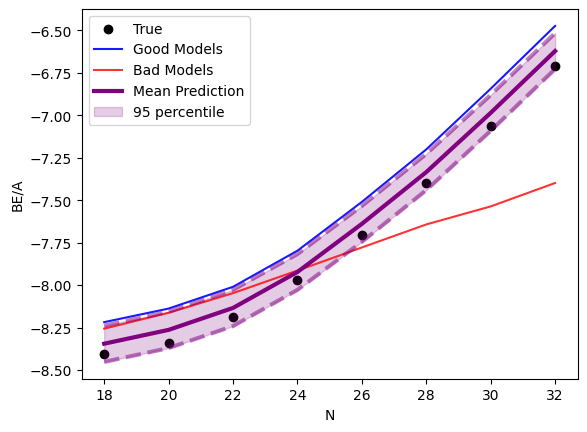

In [20]:
plt.scatter(x = filtered_models_output["N"], y = masses_truth_filtered, label = str("True"), color='k')




#good  models
legend_flag=0
for key in list(models_output.keys())[:1]:
    if legend_flag==0:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], label = "Good Models", color='b',alpha = 0.9)
        legend_flag=1
    else:
        plt.plot( filtered_models_output["N"], filtered_models_output[key], color='b',alpha = 0.5)

#bad models
legend_flag=0
for key in list(models_output.keys())[1:]:
    if legend_flag==0:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], label = "Bad Models", color ='r',alpha = 0.8)
        legend_flag=1
    else:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], color='r',alpha = 0.5)




# middle_index=len(masses_truth_filtered) // 2
# # for i in range(components_kept):
# plt.plot(filtered_models_output["N"],  U_hat.T[0][filtered_models_output.index]/(U_hat.T[0][filtered_models_output.index][middle_index])*(masses_truth_filtered[middle_index]), label = str("PC_") + str(0), alpha = 0.3)
# plt.plot(filtered_models_output["N"],U_hat.T[1][filtered_models_output.index]/(U_hat.T[1][filtered_models_output.index][middle_index])*(masses_truth_filtered[middle_index]), label = str("PC_") + str(1), alpha = 0.3)


# plt.scatter(x = models_output_df["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)





mean = np.mean(rndm_m,axis=0)
upper = (np.percentile(rndm_m, 97.5, axis=0))



lower = (np.percentile(rndm_m, 2.5, axis=0))

plt.plot(filtered_models_output["N"], mean, color="purple", label='Mean Prediction',linewidth=3)

plt.plot(filtered_models_output["N"], lower, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)
plt.plot(filtered_models_output["N"], upper, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)

plt.fill_between(filtered_models_output["N"], lower, upper, color="purple",alpha=0.2, label='95 percentile')



plt.legend()

plt.xlabel('N')

plt.ylabel('BE/A')

plt.show()

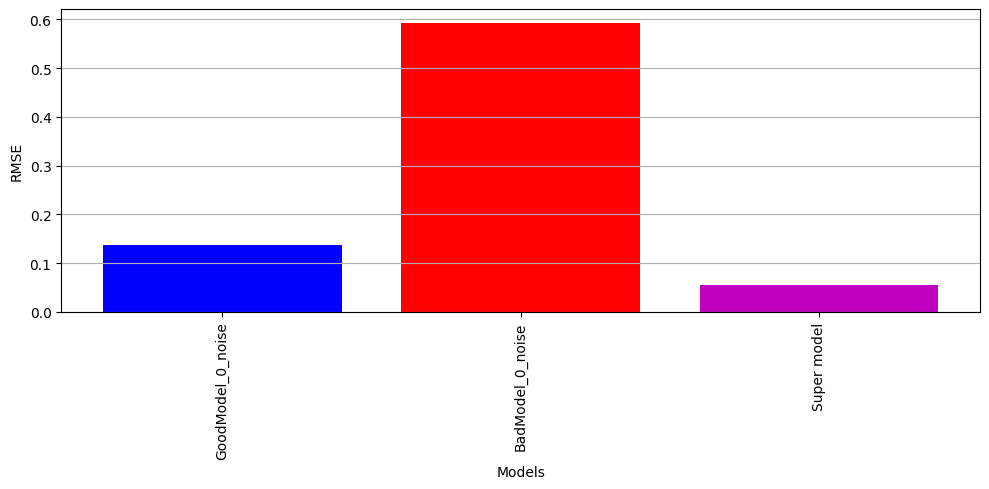

In [21]:
labels=list(models_output.keys())
plt.figure(figsize=(10, 5))
plt.bar(labels[0:1] , model_summary["rmse"][0:1], color='b')

plt.bar(labels[1:] , model_summary["rmse"][1:], color='r')

plt.bar('Super model' , np.sqrt(sigma_squared), color='m')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(labels+['Super model'],fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [22]:
np.sqrt(sigma_squared)

0.05417892829070963

In [ ]:
aaa

###  3 Good 10 Bad (noise)

In [75]:
np.shape(residuals)

(521, 13)

In [76]:
U, S, Vt = np.linalg.svd(model_predictions)

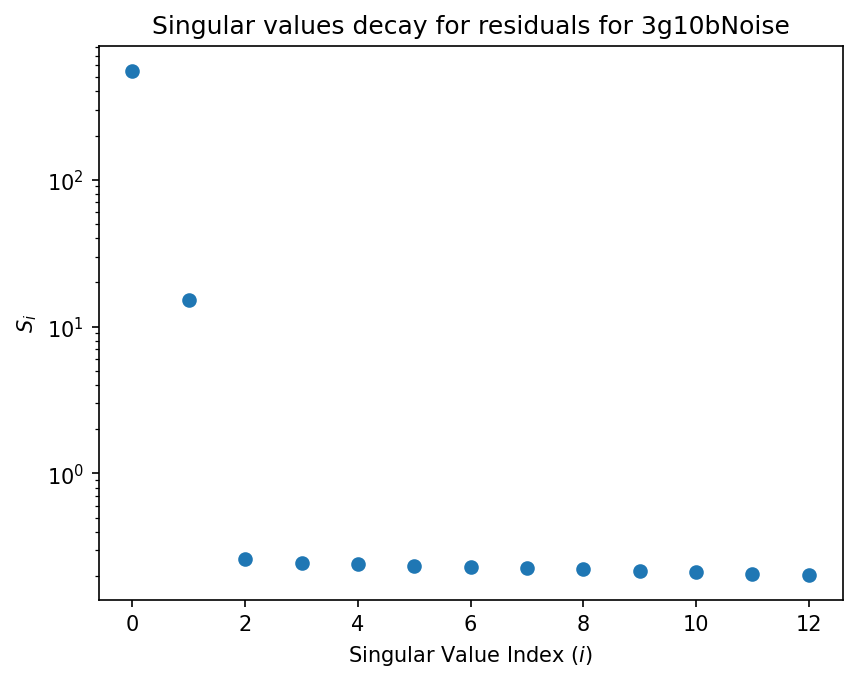

In [77]:
fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(S.size), S)

ax.set_yscale('log')
ax.set_xlabel(r'Singular Value Index ($i$)')
ax.set_ylabel(r'$S_i$');
plt.title("Singular values decay for residuals for " +scenario)
plt.show()

In [202]:
components_kept=2
S_hat=np.array([S[i] for i in range(components_kept)])

U_hat=np.array([U.T[i]*S_hat[i] for i in range(components_kept)]).T

Vt_hat=np.array([Vt[i] for i in range(components_kept)])


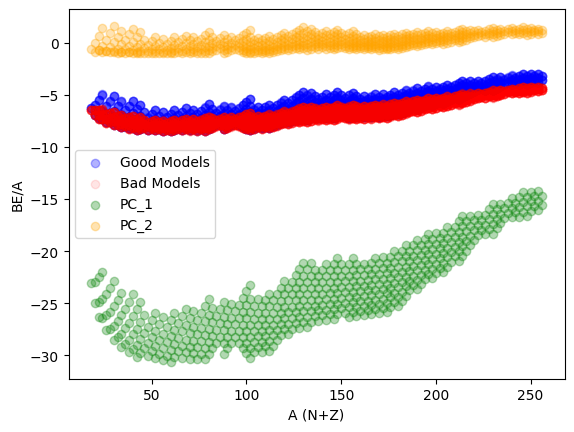

In [339]:
key_list=list(models_output.keys())


legend_flag=0
for key in key_list[0:3]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = 'Good Models', alpha = 0.3,color='b')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.3,color='b')

legend_flag=0
for key in key_list[3:]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = "Bad Models", alpha = 0.1,color='r')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.1,color='r')



# for i in range(components_kept):
plt.scatter(x = models_output_df["A"], y = U_hat.T[0], label = str("PC_") + str(1), alpha = 0.3,color='g')
plt.scatter(x = models_output_df["A"], y = U_hat.T[1], label = str("PC_") + str(2), alpha = 0.3,color='orange')
plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

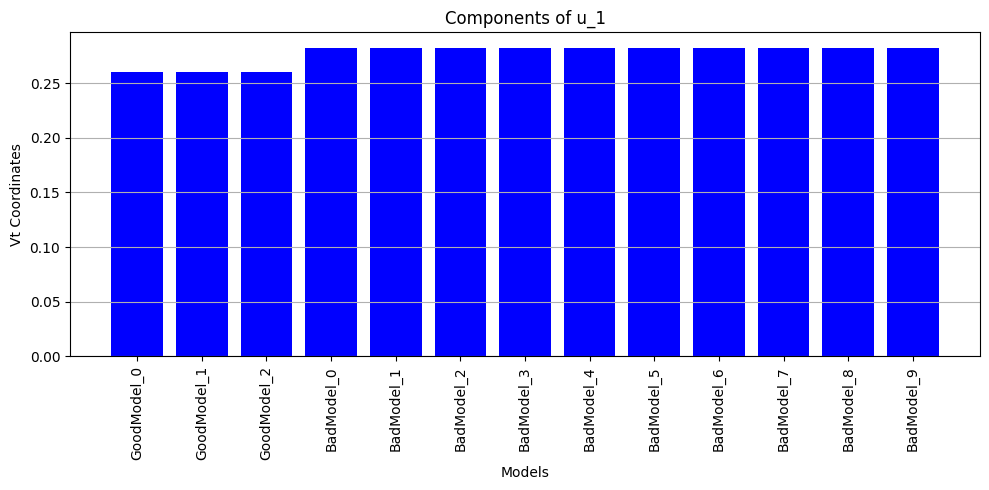

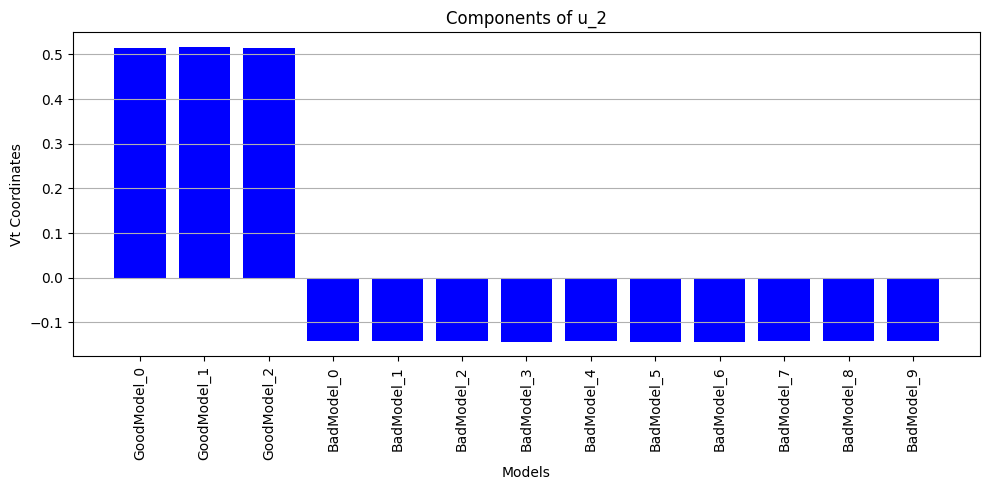

In [312]:
labels_list = list(models_output.keys())

for i in range(len(Vt_hat)):

    plot_bars(Vt_hat[i], labels_list, title=f"Components of u_{i+1}", color='blue')

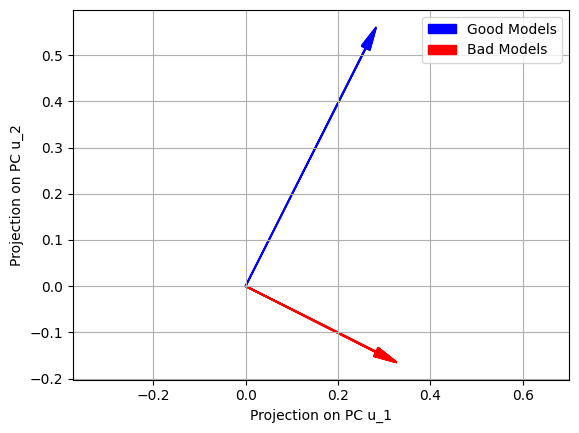

In [311]:

list1 = Vt_hat.T[0:3]
list2 = Vt_hat.T[3:] 

# Create the plot
plt.figure()
plt.grid(True)

legend_flag=0
for x, y in list1:
    if legend_flag==0:
        legend_flag=1
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='blue', ec='blue',label='Good Models')
    else:
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='blue', ec='blue')


legend_flag=0
for x, y in list2:
    if legend_flag==0:
        legend_flag=1
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='red', ec='red',label="Bad Models")
    else:
       plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='red', ec='red') 

# Determine plot limits based on the maximum absolute values of the vectors
# max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
# plt.xlim(-max_val-1, max_val+1)
# plt.ylim(-max_val-1, max_val+1)

plt.xlabel('Projection on PC u_1')
plt.ylabel('Projection on PC u_2')

plt.legend()

plt.axis('equal')

plt.show()


In [211]:
X=np.copy(U_hat).T
y=np.copy(masses_truth.tolist())

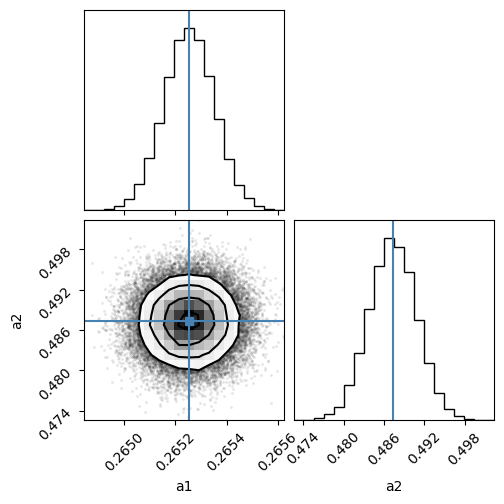

In [212]:
# 1) Find the least square solution
X_T_X_inv = np.linalg.inv(X.dot(X.T))
beta = X_T_X_inv.dot(X).dot(y)
supermodel=X.T.dot(beta)

# 2) Construct the covariance matrix
residuals = y - supermodel
sigma_squared = np.sum(residuals**2) / len(residuals) 
cov_matrix = sigma_squared * X_T_X_inv

# 3) Make a corner plot
samples = np.random.multivariate_normal(beta, cov_matrix, size=50000)
figure = corner.corner(samples, labels=[f'a{i}' for i in range(1, len(beta) + 1)], truths=beta)

plt.show()

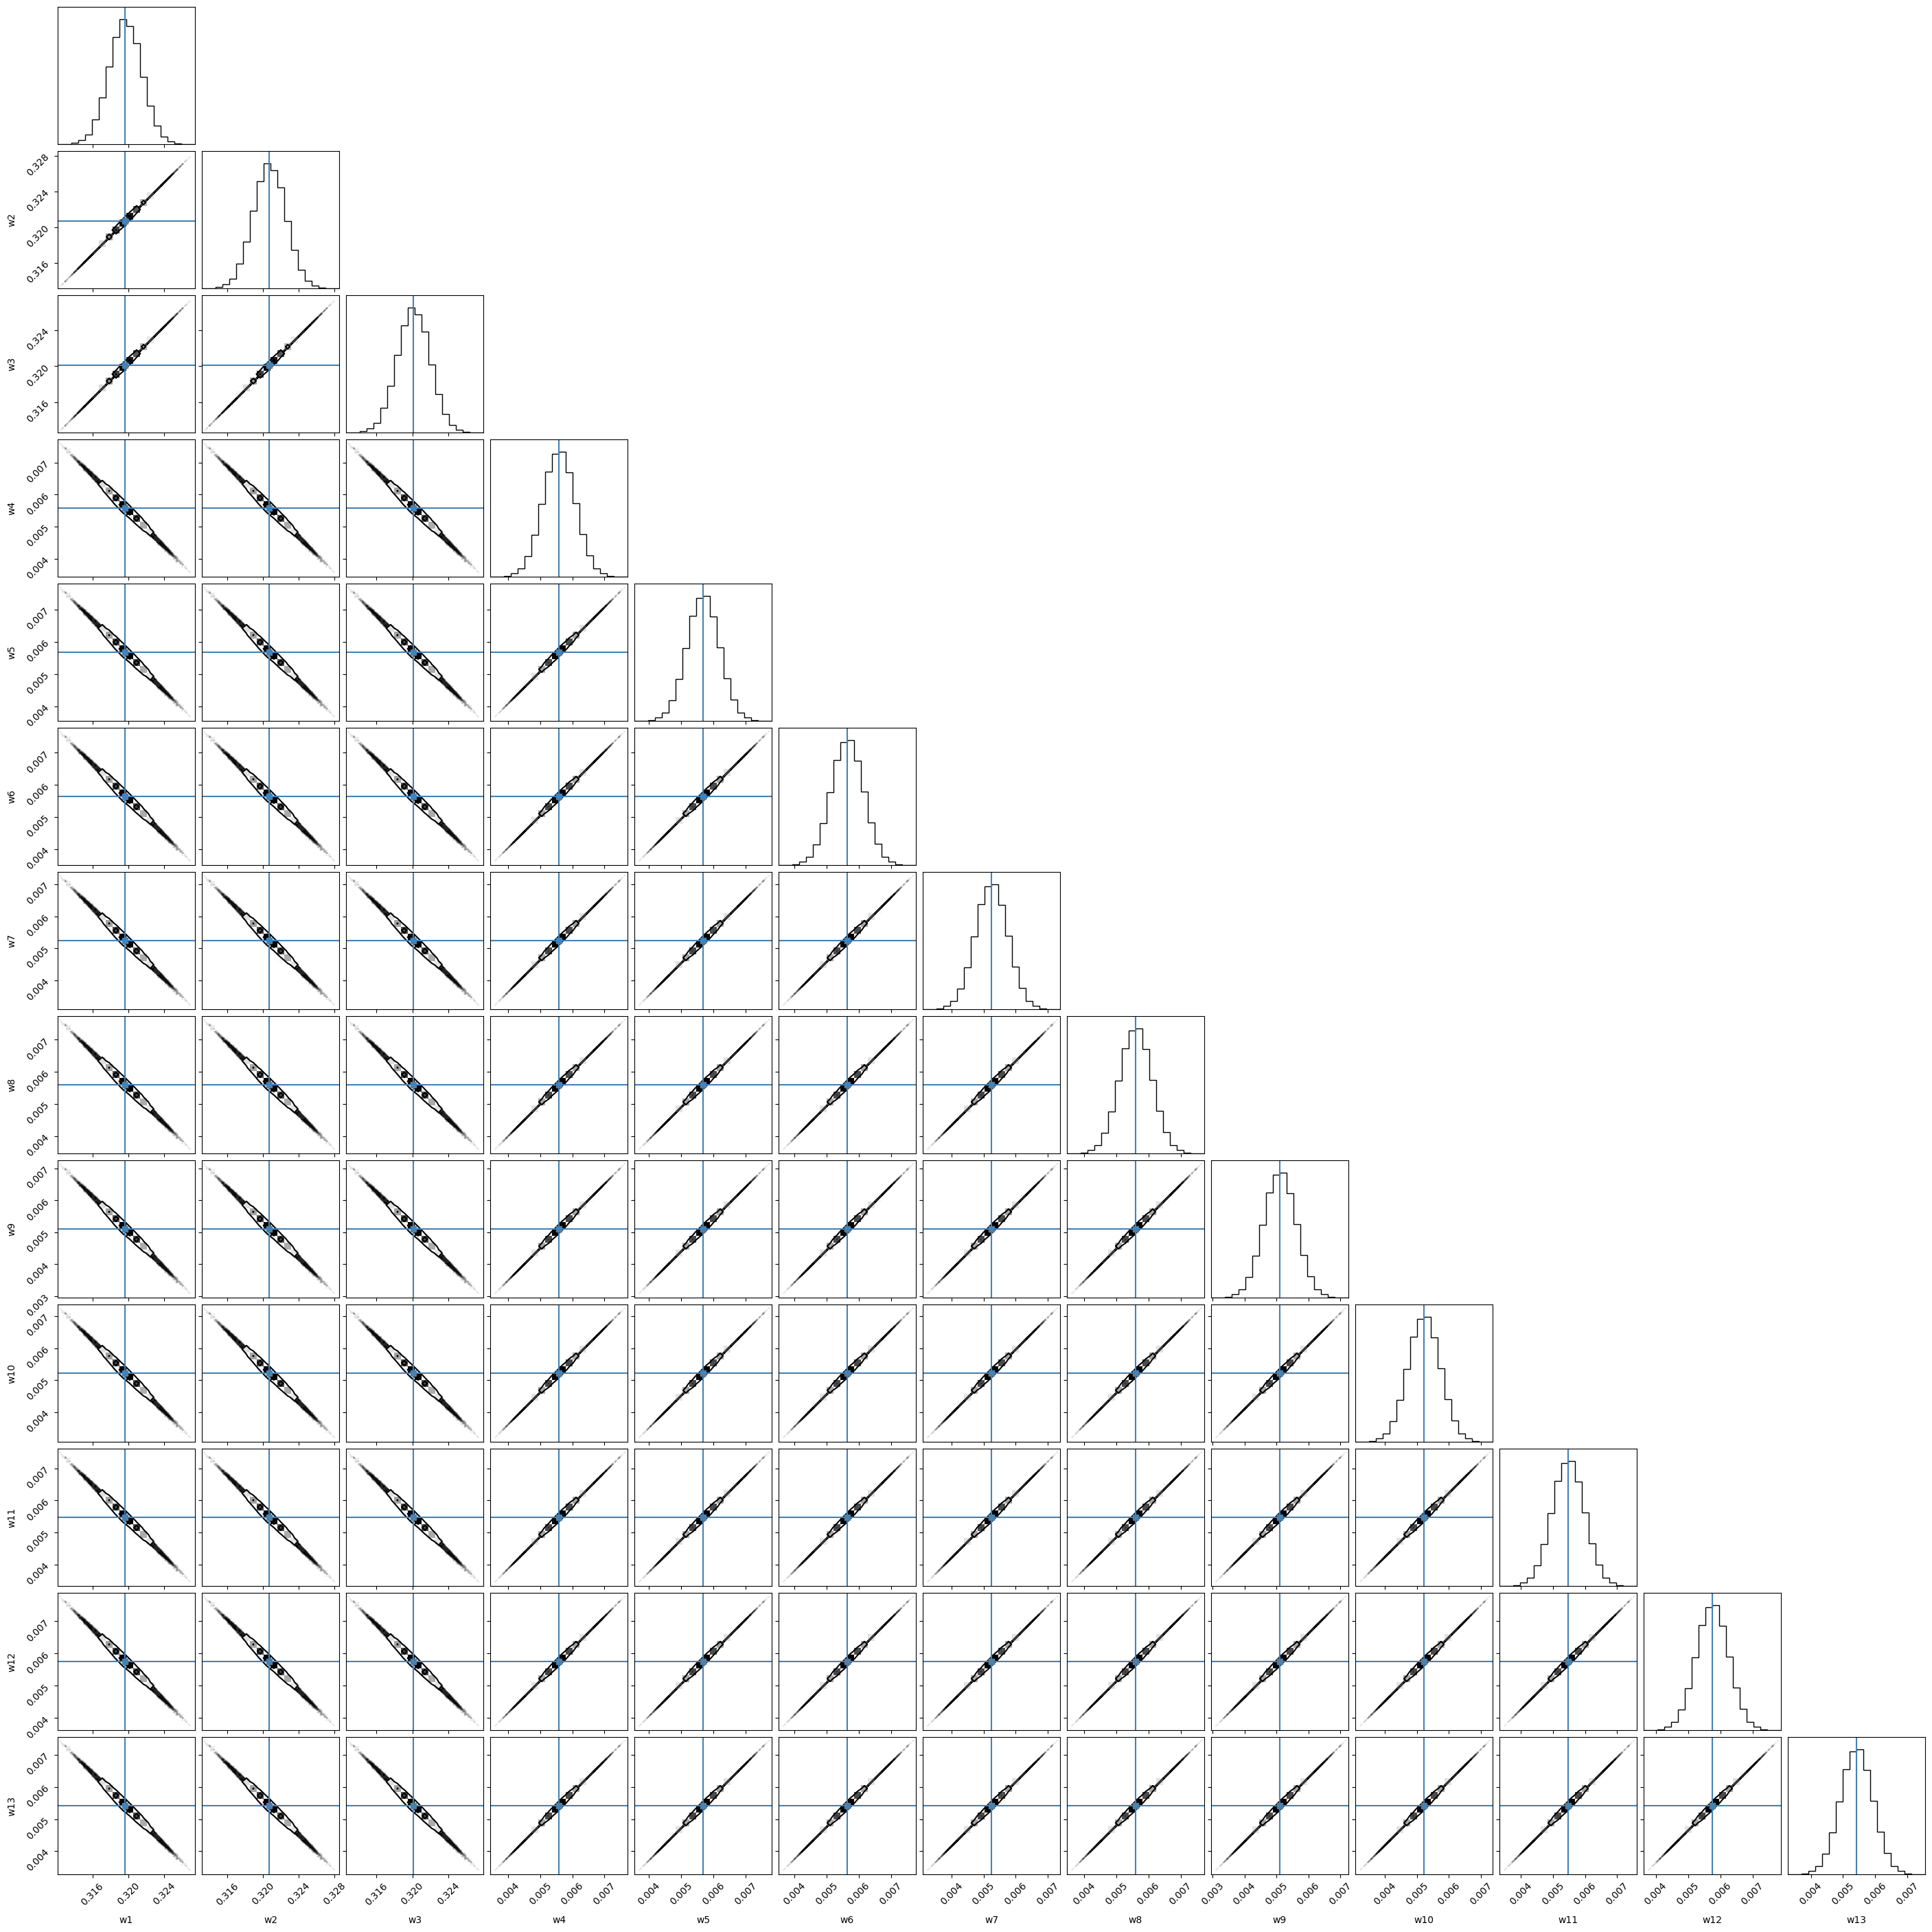

In [263]:
# 4) Make a corner plot in the space of the original models
samples_original_space = np.array([np.dot(betaval,Vt_hat)  for  betaval in samples])


figure = corner.corner(samples_original_space, labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat))
# figure = corner.corner(samples_original_space)

plt.show()

In [264]:
beta

array([0.26525345, 0.4872735 ])

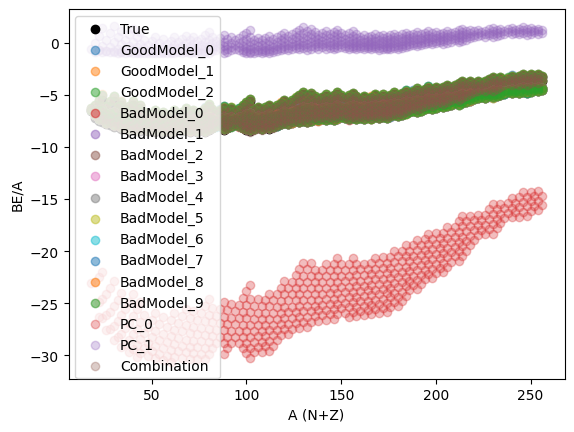

In [265]:
# for key in models_output.keys():
#     plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = masses_truth.values[:,None], label = str("True"), color='k')



for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
# 


# for i in range(components_kept):
plt.scatter(x = models_output_df["A"], y =U_hat.T[0], label = str("PC_") + str(0), alpha = 0.3)
plt.scatter(x = models_output_df["A"], y = U_hat.T[1], label = str("PC_") + str(1), alpha = 0.3)


# plt.scatter(x = models_output_df["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = supermodel, label = str("Combination"), alpha = 0.3)


plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

In [266]:
Z_range=(20,20)
N_range=(0,300)


filtered_models_output = models_output_df[(models_output_df['Z'] >= Z_range[0]) & (models_output_df['Z'] <= Z_range[1]) & 
                     (models_output_df['N'] >= N_range[0]) & (models_output_df['N'] <= N_range[1])]

In [267]:
Predictions_supermodel=supermodel[filtered_models_output.index]
masses_truth_filtered= np.array(masses_truth.tolist())[filtered_models_output.index]

In [268]:
masses_truth_filtered

array([-8.40668771, -8.34027003, -8.18890254, -7.97132217, -7.70318603,
       -7.3972354 , -7.0636683 , -6.71055621])

In [269]:
Predictions_supermodel

array([-8.33775038, -8.2806572 , -8.14129448, -7.91619521, -7.63868216,
       -7.32438315, -6.98648626, -6.62226156])

In [270]:
rng = np.random.default_rng()
theta_rand = rng.choice(samples, (50000), replace=False)
rndm_m = []

for i in range(len(theta_rand)):
    yvals_rand= X.T.dot(theta_rand[i])[filtered_models_output.index]
    rndm_m.append(yvals_rand +
                   np.random.multivariate_normal(np.full(
                       len(masses_truth_filtered)
                       ,0), np.diag(1.0 * np.full(len(masses_truth_filtered),1.0 * sigma_squared ) )))   

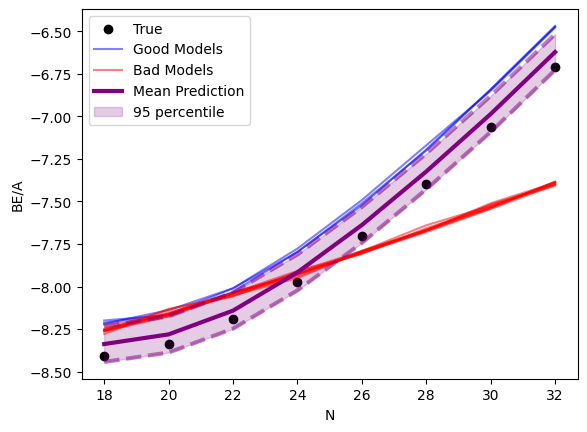

In [271]:
plt.scatter(x = filtered_models_output["N"], y = masses_truth_filtered, label = str("True"), color='k')




#good  models
legend_flag=0
for key in list(models_output.keys())[:3]:
    if legend_flag==0:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], label = "Good Models", color='b',alpha = 0.5)
        legend_flag=1
    else:
        plt.plot( filtered_models_output["N"], filtered_models_output[key], color='b',alpha = 0.5)

#bad models
legend_flag=0
for key in list(models_output.keys())[3:]:
    if legend_flag==0:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], label = "Bad Models", color ='r',alpha = 0.5)
        legend_flag=1
    else:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], color='r',alpha = 0.5)




# middle_index=len(masses_truth_filtered) // 2
# # for i in range(components_kept):
# plt.plot(filtered_models_output["N"],  U_hat.T[0][filtered_models_output.index]/(U_hat.T[0][filtered_models_output.index][middle_index])*(masses_truth_filtered[middle_index]), label = str("PC_") + str(0), alpha = 0.3)
# plt.plot(filtered_models_output["N"],U_hat.T[1][filtered_models_output.index]/(U_hat.T[1][filtered_models_output.index][middle_index])*(masses_truth_filtered[middle_index]), label = str("PC_") + str(1), alpha = 0.3)


# plt.scatter(x = models_output_df["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)





mean = np.mean(rndm_m,axis=0)
upper = (np.percentile(rndm_m, 97.5, axis=0))



lower = (np.percentile(rndm_m, 2.5, axis=0))

plt.plot(filtered_models_output["N"], mean, color="purple", label='Mean Prediction',linewidth=3)

plt.plot(filtered_models_output["N"], lower, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)
plt.plot(filtered_models_output["N"], upper, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)

plt.fill_between(filtered_models_output["N"], lower, upper, color="purple",alpha=0.2, label='95 percentile')



plt.legend()

plt.xlabel('N')

plt.ylabel('BE/A')

plt.show()

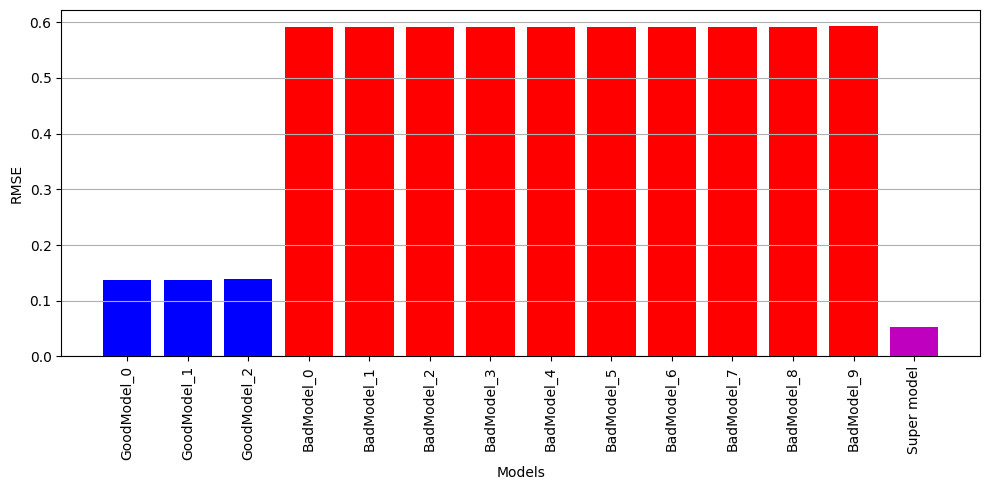

In [325]:
labels=list(models_output.keys())
plt.figure(figsize=(10, 5))
plt.bar(labels[0:3] , model_summary["rmse"][0:3], color='b')

plt.bar(labels[3:] , model_summary["rmse"][3:], color='r')

plt.bar('Super model' , np.sqrt(sigma_squared), color='m')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(labels+['Super model'],fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [372]:
np.sqrt(sigma_squared)

0.05417892829070963

###  1 Perfect 3 Good 10 Bad (noise)

In [27]:
np.shape(residuals)

(521, 14)

In [28]:
U, S, Vt = np.linalg.svd(model_predictions)

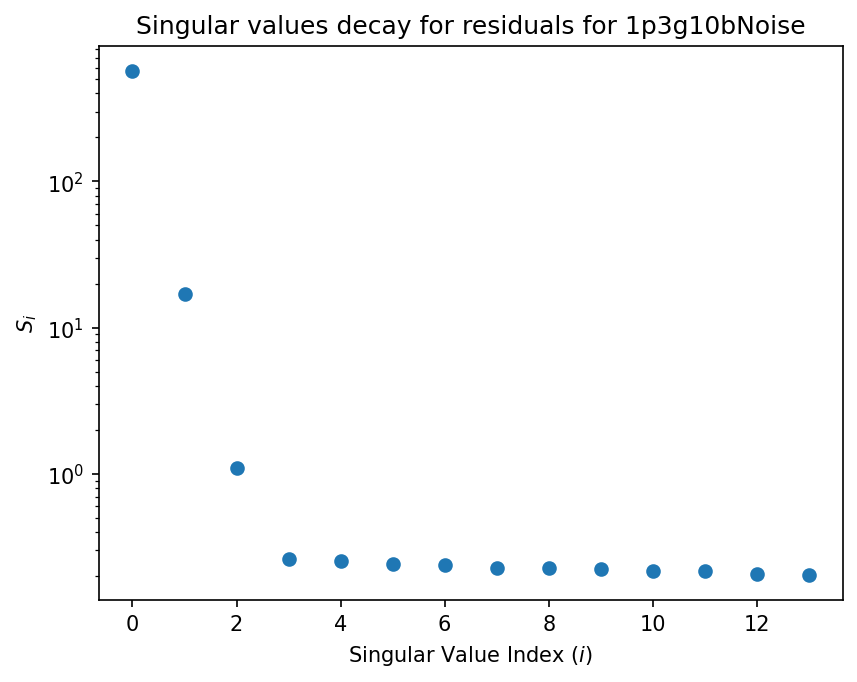

In [29]:
fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(S.size), S)

ax.set_yscale('log')
ax.set_xlabel(r'Singular Value Index ($i$)')
ax.set_ylabel(r'$S_i$');
plt.title("Singular values decay for residuals for " +scenario)
plt.show()

In [34]:
components_kept=3
S_hat=np.array([S[i] for i in range(components_kept)])

U_hat=np.array([U.T[i]*S_hat[i] for i in range(components_kept)]).T

Vt_hat=np.array([Vt[i] for i in range(components_kept)])


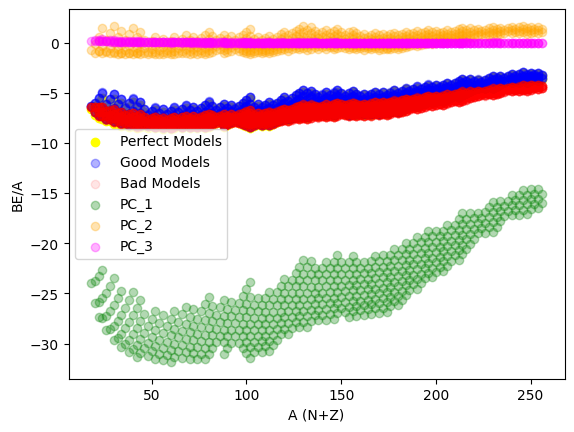

In [38]:
key_list=list(models_output.keys())
plt.scatter(x = models_output_df["A"], y = models_output_df[key_list[0]], label = 'Perfect Models',color='yellow')

legend_flag=0
for key in key_list[1:4]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = 'Good Models', alpha = 0.3,color='b')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.3,color='b')

legend_flag=0
for key in key_list[4:]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = "Bad Models", alpha = 0.1,color='r')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.1,color='r')



# for i in range(components_kept):
plt.scatter(x = models_output_df["A"], y = U_hat.T[0], label = str("PC_") + str(1), alpha = 0.3,color='g')
plt.scatter(x = models_output_df["A"], y = U_hat.T[1], label = str("PC_") + str(2), alpha = 0.3,color='orange')

plt.scatter(x = models_output_df["A"], y = U_hat.T[2], label = str("PC_") + str(3), alpha = 0.3,color='magenta')

plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

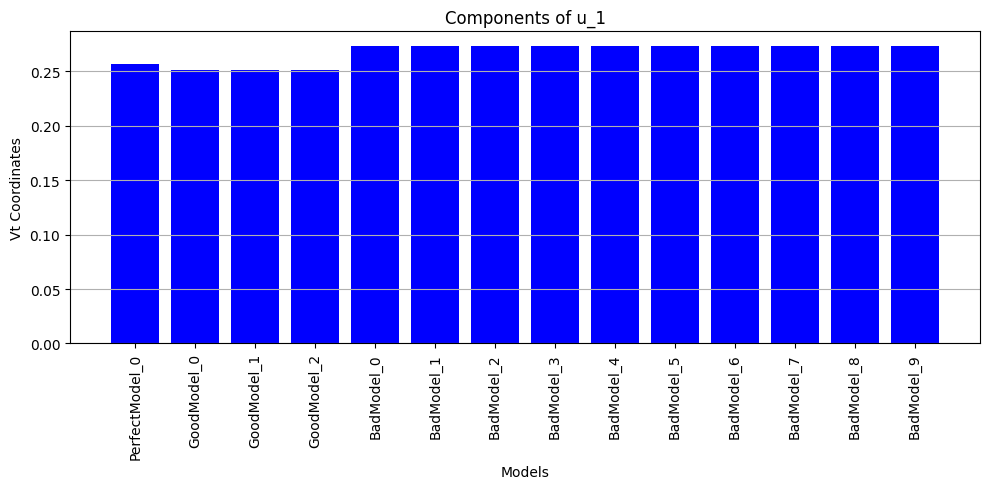

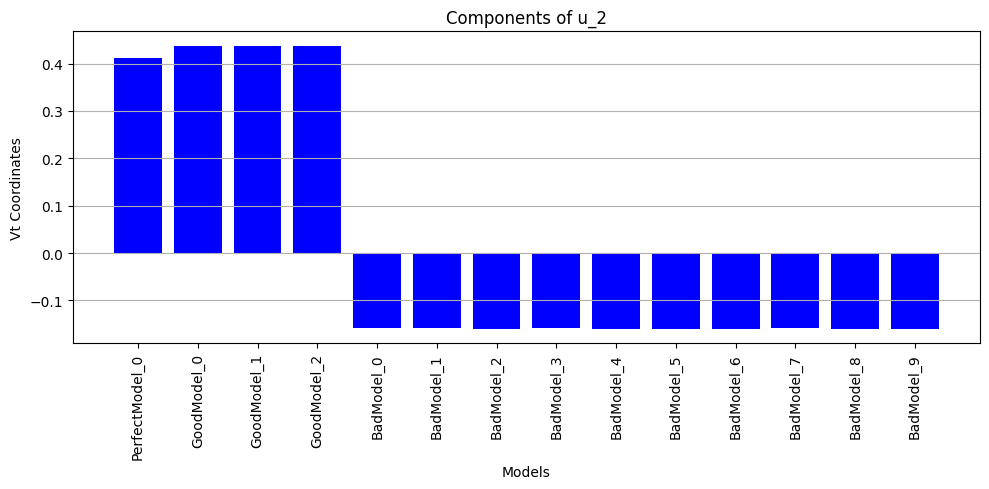

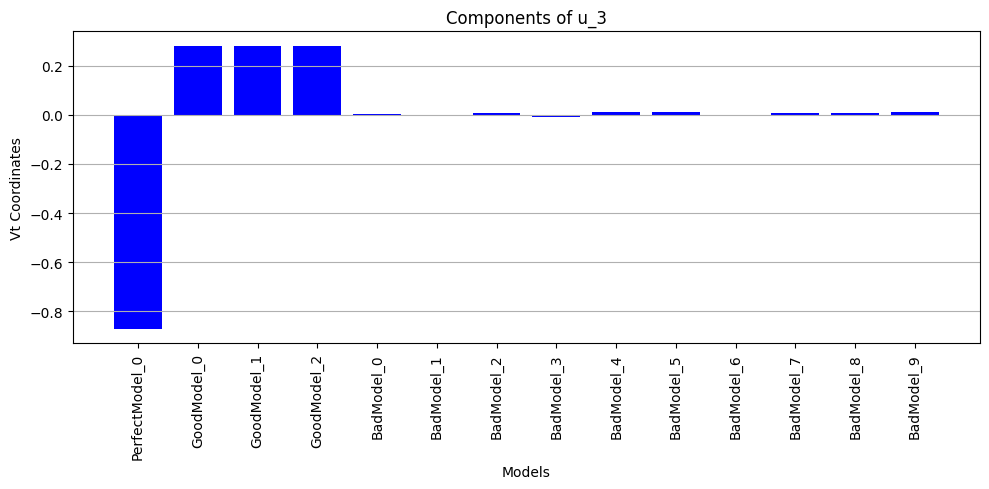

In [39]:
labels_list = list(models_output.keys())

for i in range(len(Vt_hat)):

    plot_bars(Vt_hat[i], labels_list, title=f"Components of u_{i+1}", color='blue')

In [51]:
Vt_hatT12=np.array([Vt_hat[0],Vt_hat[1]])

In [60]:
Vt_hatT13=np.array([Vt_hat[0],Vt_hat[2]])

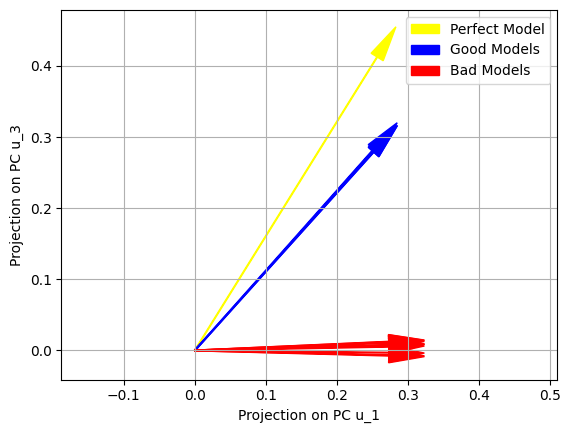

In [62]:
list0=Vt_hatT13.T[0]
list1 = Vt_hatT13.T[1:4]
list2 = Vt_hatT13.T[4:] 

# Create the plot
plt.figure()
plt.grid(True)


plt.arrow(0, 0, Vt_hatT12.T[0][0], Vt_hatT12.T[0][1], head_width=0.02, head_length=0.05, fc='yellow', ec='yellow',label='Perfect Model')

legend_flag=0
for x, y in list1:
    if legend_flag==0:
        legend_flag=1
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='blue', ec='blue',label='Good Models')
    else:
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='blue', ec='blue')


legend_flag=0
for x, y in list2:
    if legend_flag==0:
        legend_flag=1
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='red', ec='red',label="Bad Models")
    else:
       plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='red', ec='red') 

# Determine plot limits based on the maximum absolute values of the vectors
# max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
# plt.xlim(-max_val-1, max_val+1)
# plt.ylim(-max_val-1, max_val+1)

plt.xlabel('Projection on PC u_1')
plt.ylabel('Projection on PC u_3')

plt.legend()

plt.axis('equal')

plt.show()


In [63]:
X=np.copy(U_hat).T
y=np.copy(masses_truth.tolist())

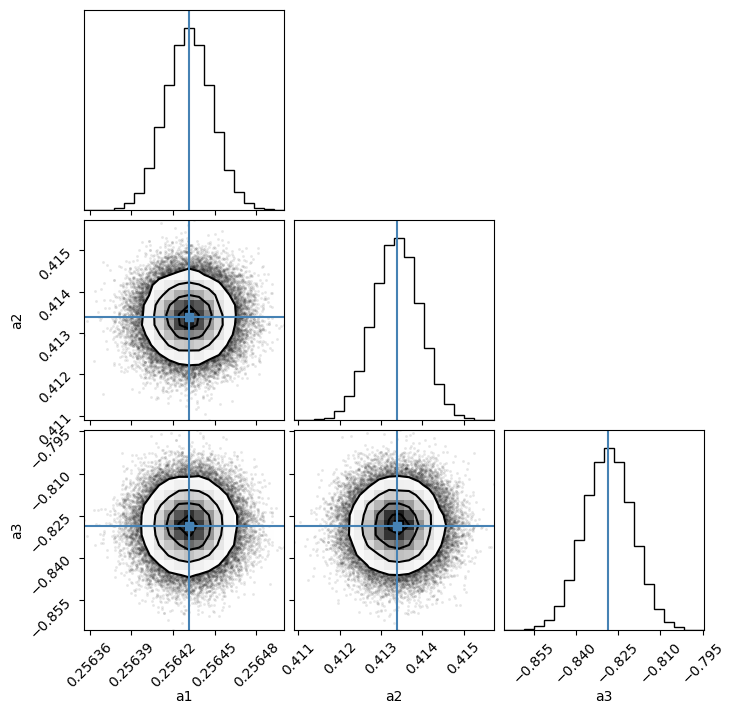

In [64]:
# 1) Find the least square solution
X_T_X_inv = np.linalg.inv(X.dot(X.T))
beta = X_T_X_inv.dot(X).dot(y)
supermodel=X.T.dot(beta)

# 2) Construct the covariance matrix
residuals = y - supermodel
sigma_squared = np.sum(residuals**2) / len(residuals) 
cov_matrix = sigma_squared * X_T_X_inv

# 3) Make a corner plot
samples = np.random.multivariate_normal(beta, cov_matrix, size=50000)
figure = corner.corner(samples, labels=[f'a{i}' for i in range(1, len(beta) + 1)], truths=beta)

plt.show()

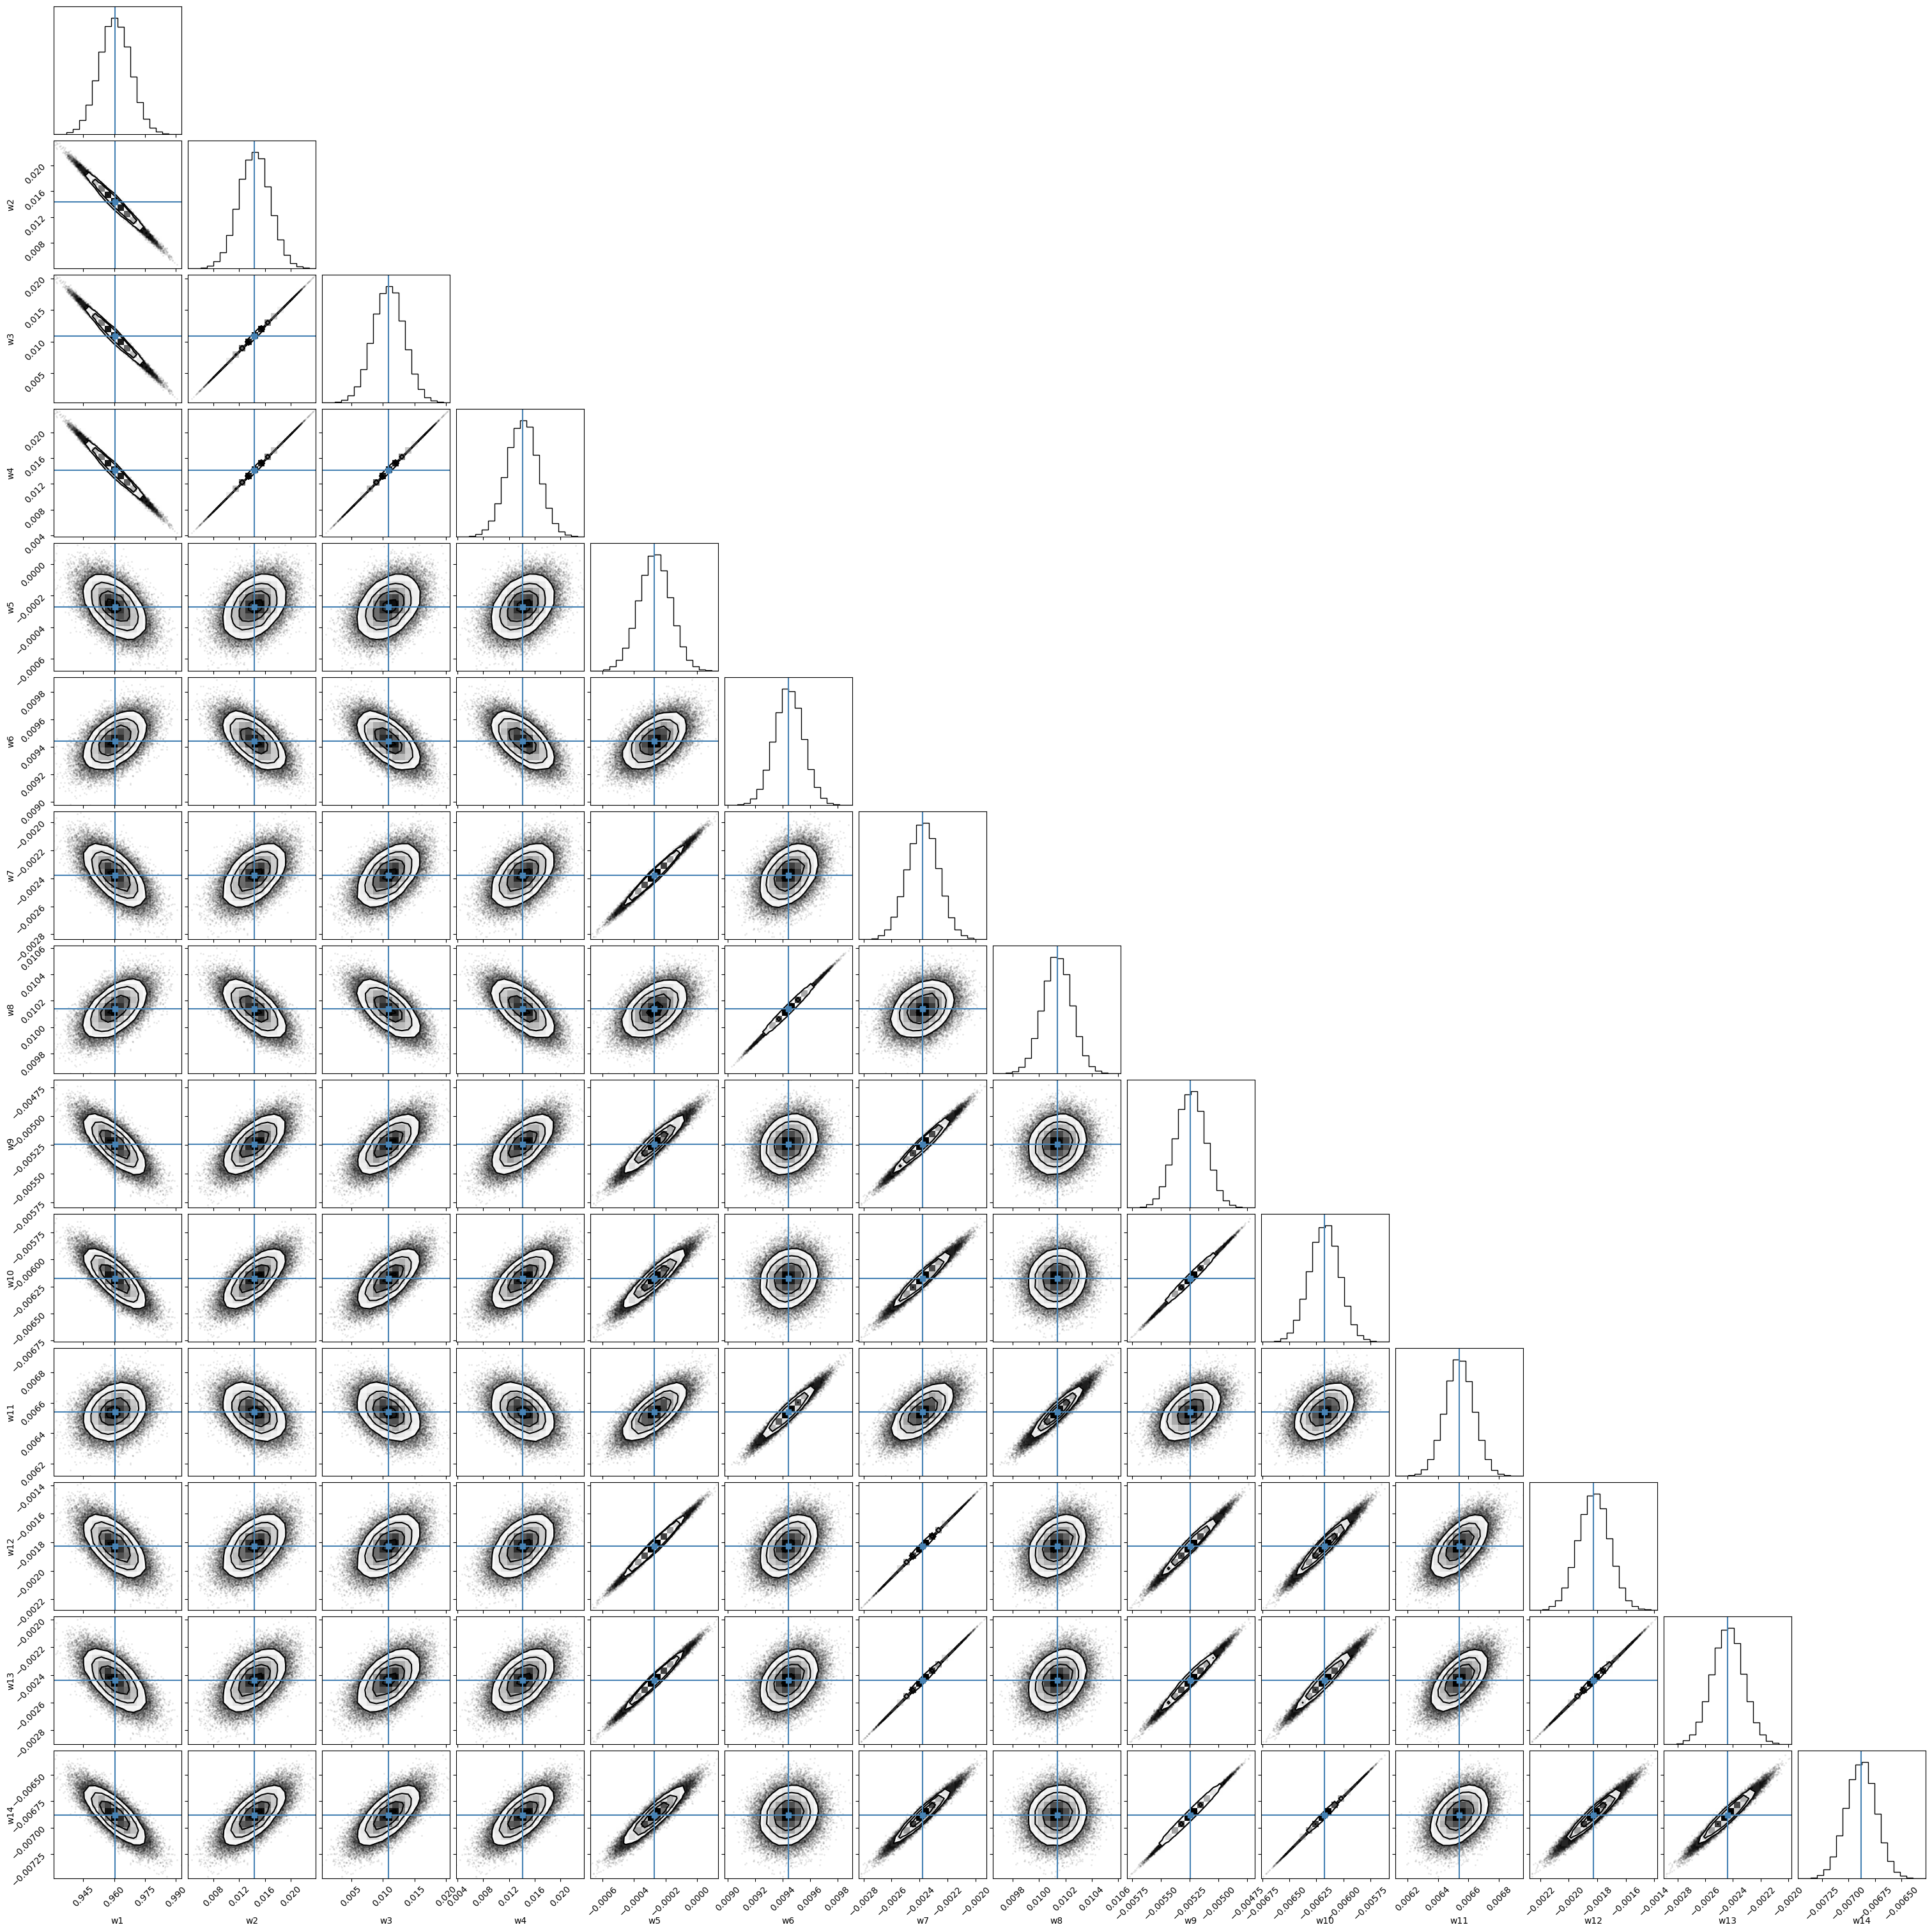

In [65]:
# 4) Make a corner plot in the space of the original models
samples_original_space = np.array([np.dot(betaval,Vt_hat)  for  betaval in samples])


figure = corner.corner(samples_original_space, labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat))
# figure = corner.corner(samples_original_space)

plt.show()

In [66]:
beta

array([ 0.25643138,  0.41338591, -0.82855256])

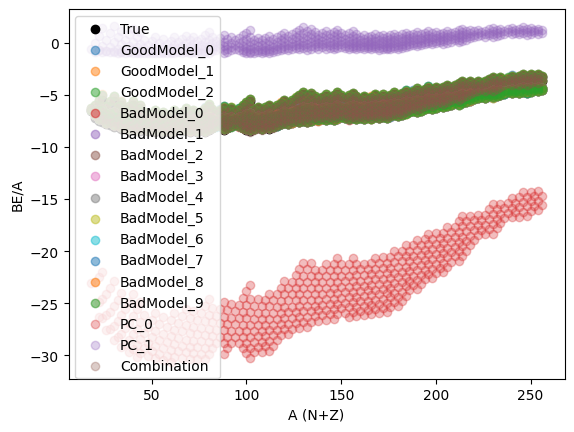

In [ ]:
# for key in models_output.keys():
#     plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = masses_truth.values[:,None], label = str("True"), color='k')



for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
# 


# for i in range(components_kept):
plt.scatter(x = models_output_df["A"], y =U_hat.T[0], label = str("PC_") + str(0), alpha = 0.3)
plt.scatter(x = models_output_df["A"], y = U_hat.T[1], label = str("PC_") + str(1), alpha = 0.3)


# plt.scatter(x = models_output_df["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = supermodel, label = str("Combination"), alpha = 0.3)


plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

In [67]:
Z_range=(20,20)
N_range=(0,300)


filtered_models_output = models_output_df[(models_output_df['Z'] >= Z_range[0]) & (models_output_df['Z'] <= Z_range[1]) & 
                     (models_output_df['N'] >= N_range[0]) & (models_output_df['N'] <= N_range[1])]

In [68]:
Predictions_supermodel=supermodel[filtered_models_output.index]
masses_truth_filtered= np.array(masses_truth.tolist())[filtered_models_output.index]

In [69]:
masses_truth_filtered

array([-8.40668771, -8.34027003, -8.18890254, -7.97132217, -7.70318603,
       -7.3972354 , -7.0636683 , -6.71055621])

In [70]:
Predictions_supermodel

array([-8.40911228, -8.32134697, -8.19007249, -7.97913297, -7.69974243,
       -7.40099782, -7.06118585, -6.71168027])

In [71]:
np.sqrt(sigma_squared)

0.009532536386160723

In [72]:
rng = np.random.default_rng()
theta_rand = rng.choice(samples, (50000), replace=False)
rndm_m = []

for i in range(len(theta_rand)):
    yvals_rand= X.T.dot(theta_rand[i])[filtered_models_output.index]
    rndm_m.append(yvals_rand +
                   np.random.multivariate_normal(np.full(
                       len(masses_truth_filtered)
                       ,0), np.diag(1.0 * np.full(len(masses_truth_filtered),1.0 * sigma_squared ) )))   

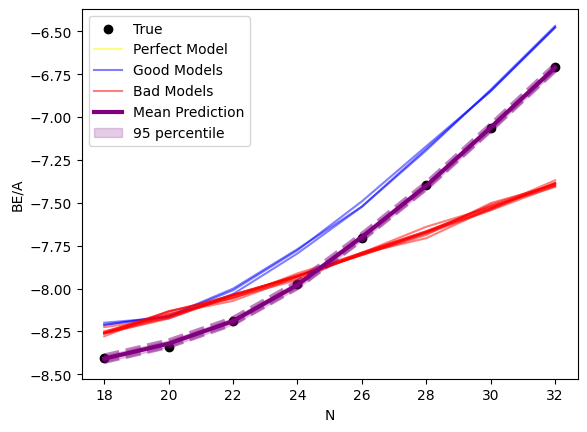

In [73]:
plt.scatter(x = filtered_models_output["N"], y = masses_truth_filtered, label = str("True"), color='k')



plt.plot(filtered_models_output["N"], filtered_models_output[list(models_output.keys())[0]], label = "Perfect Model", color='yellow',alpha = 0.5)

#good  models
legend_flag=0
for key in list(models_output.keys())[1:4]:
    if legend_flag==0:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], label = "Good Models", color='b',alpha = 0.5)
        legend_flag=1
    else:
        plt.plot( filtered_models_output["N"], filtered_models_output[key], color='b',alpha = 0.5)

#bad models
legend_flag=0
for key in list(models_output.keys())[4:]:
    if legend_flag==0:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], label = "Bad Models", color ='r',alpha = 0.5)
        legend_flag=1
    else:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], color='r',alpha = 0.5)




# middle_index=len(masses_truth_filtered) // 2
# # for i in range(components_kept):
# plt.plot(filtered_models_output["N"],  U_hat.T[0][filtered_models_output.index]/(U_hat.T[0][filtered_models_output.index][middle_index])*(masses_truth_filtered[middle_index]), label = str("PC_") + str(0), alpha = 0.3)
# plt.plot(filtered_models_output["N"],U_hat.T[1][filtered_models_output.index]/(U_hat.T[1][filtered_models_output.index][middle_index])*(masses_truth_filtered[middle_index]), label = str("PC_") + str(1), alpha = 0.3)


# plt.scatter(x = models_output_df["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)





mean = np.mean(rndm_m,axis=0)
upper = (np.percentile(rndm_m, 97.5, axis=0))



lower = (np.percentile(rndm_m, 2.5, axis=0))

plt.plot(filtered_models_output["N"], mean, color="purple", label='Mean Prediction',linewidth=3)

plt.plot(filtered_models_output["N"], lower, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)
plt.plot(filtered_models_output["N"], upper, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)

plt.fill_between(filtered_models_output["N"], lower, upper, color="purple",alpha=0.2, label='95 percentile')



plt.legend()

plt.xlabel('N')

plt.ylabel('BE/A')

plt.show()

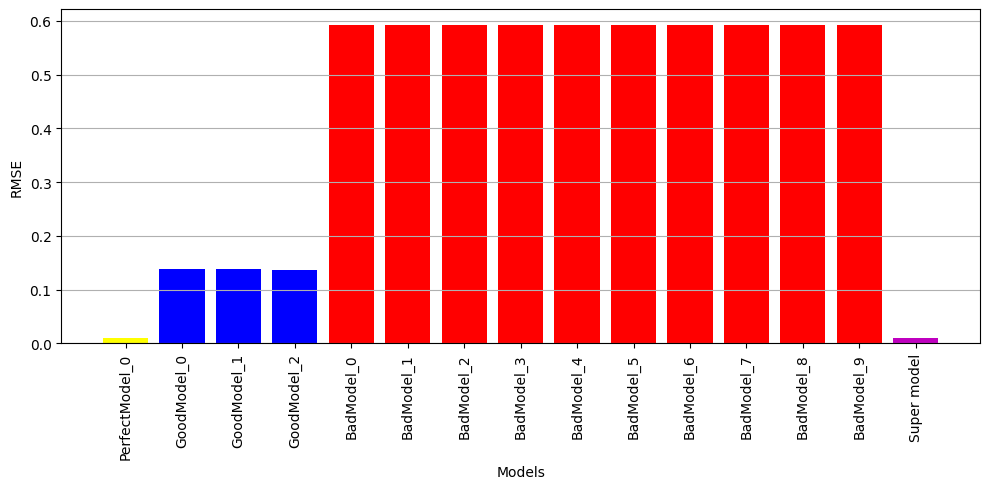

In [74]:
labels=list(models_output.keys())
plt.figure(figsize=(10, 5))
plt.bar(labels[0] , model_summary["rmse"][0], color='yellow')
plt.bar(labels[1:4] , model_summary["rmse"][1:4], color='b')

plt.bar(labels[4:] , model_summary["rmse"][4:], color='r')

plt.bar('Super model' , np.sqrt(sigma_squared), color='m')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(labels+['Super model'],fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [75]:
np.sqrt(sigma_squared)

0.009532536386160723